<a href="https://colab.research.google.com/github/spdrnl/ecg/blob/master/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

# Move data from Drive to /tmp

In [147]:
# You can obtain the data from Kaggle at https://www.kaggle.com/shayanfazeli/heartbeat
from google.colab import drive
drive.mount("/tmp/drive")
! unzip "/tmp/drive/My Drive/data/29414_37484_bundle_archive.zip" -d /tmp/ecg
! ls /tmp/ecg

Drive already mounted at /tmp/drive; to attempt to forcibly remount, call drive.mount("/tmp/drive", force_remount=True).
Archive:  /tmp/drive/My Drive/data/29414_37484_bundle_archive.zip
replace /tmp/ecg/mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


# Import and analyse data
## MIT-BIH Arhythmia dataset

In [148]:
mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv", header=None)

In [149]:
mitbih_train.shape

(87554, 188)

### Explore feature and label distribution

In [150]:
mitbih_labels = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train_labels = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)

Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arhythmia dataset')

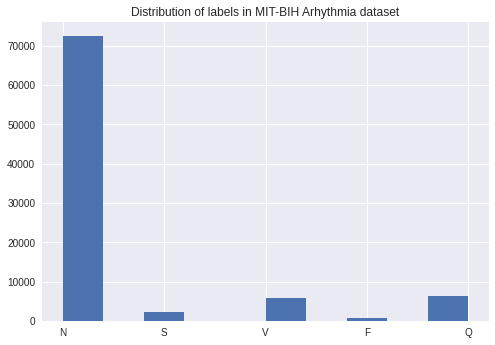

In [151]:
plt.hist(mitbih_train_labels)
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

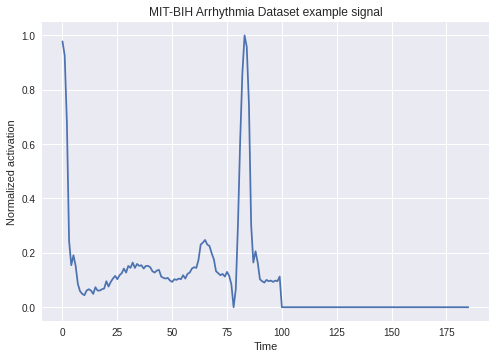

In [152]:
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

### Explore data quality

In [153]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [154]:
print("The minimum and maximum values are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


## PTB Diagnostic ECG Database

In [155]:
ptbdb_abnormal = pd.read_csv("/tmp/ecg/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("/tmp/ecg/ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)

In [156]:
ptbdb.shape

(14552, 188)

In [157]:
ptbdb_abnormal.values[:,-1] # Abnormal is labelled one as per convention

array([1., 1., 1., ..., 1., 1., 1.])

### Explore features and labels

In [158]:
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb_labels = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)

Text(0.5, 1.0, 'Distribution of the PTB Diagnostic ECG Database labels')

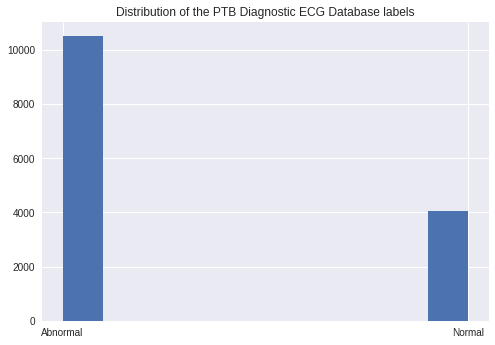

In [159]:
plt.hist(ptbdb_labels)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")

### Explore data quality

In [160]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [161]:
print("The minimum and maximum values are {}, {}".format(np.min(ptbdb.iloc[:,:-2].values), np.max(ptbdb.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'PTB Diagnostic ECG Database example signal')

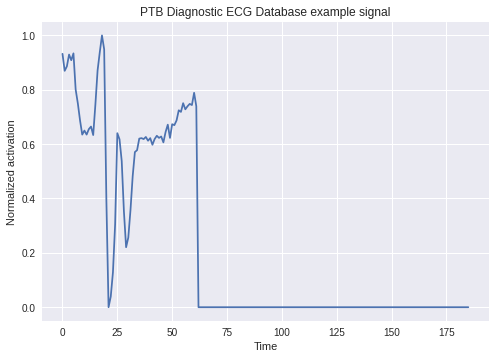

In [162]:
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")

# Helper functions

In [163]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [164]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [165]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Baseline MLP

In [166]:
def get_base_model(categories=2):
  return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])

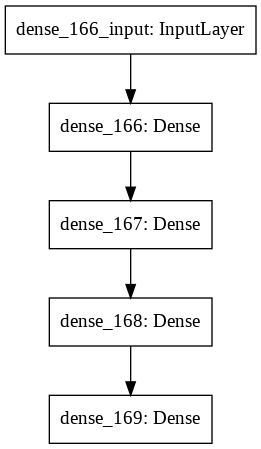

In [167]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

## Baseline PTB check

In [168]:
X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)
X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_test, y_ptbdb_test, test_size=0.5, random_state=42)

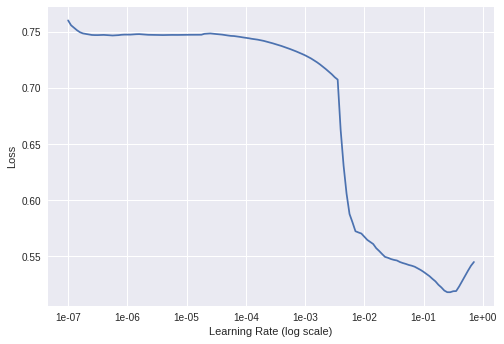

In [169]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-2, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdb_train, y_ptbdb_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [206]:
# Set cyclical learning rate
N = X_ptbdb_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-4, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

base_model = get_base_model() 
base_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = base_model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val), 
                         shuffle=True, batch_size=batch_size, epochs=150, callbacks=[save_best_weights])

Epoch 1/150
91/91 [==============================] - 1s 6ms/step - loss: 0.5419 - accuracy: 0.7311 - val_loss: 0.4139 - val_accuracy: 0.8022
Epoch 2/150
91/91 [==============================] - 0s 4ms/step - loss: 0.4025 - accuracy: 0.8028 - val_loss: 0.3943 - val_accuracy: 0.7967
Epoch 3/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3644 - accuracy: 0.8306 - val_loss: 0.3212 - val_accuracy: 0.8297
Epoch 4/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3264 - accuracy: 0.8571 - val_loss: 0.3222 - val_accuracy: 0.8297
Epoch 5/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3068 - accuracy: 0.8699 - val_loss: 0.3163 - val_accuracy: 0.8462
Epoch 6/150
91/91 [==============================] - 0s 5ms/step - loss: 0.3038 - accuracy: 0.8705 - val_loss: 0.3896 - val_accuracy: 0.8132
Epoch 7/150
91/91 [==============================] - 0s 4ms/step - loss: 0.2911 - accuracy: 0.8784 - val_loss: 0.3101 - val_accuracy: 0.8626
Epoch 8/150
9

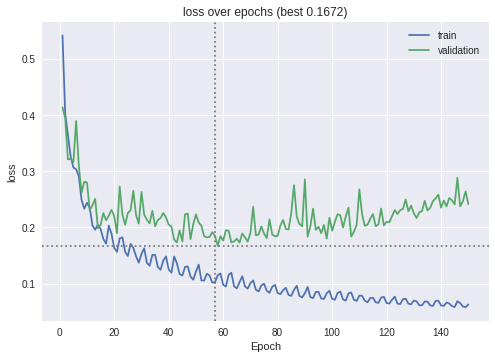

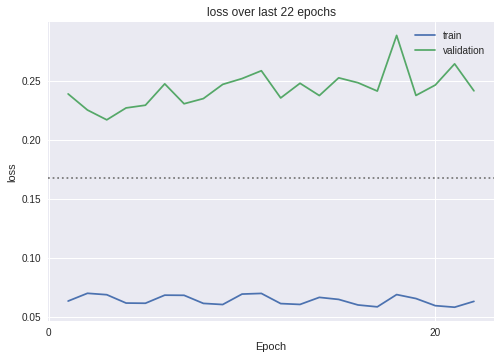

In [207]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

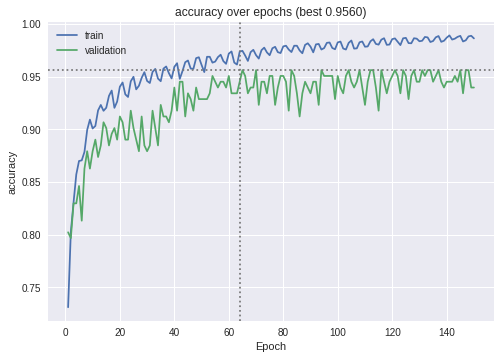

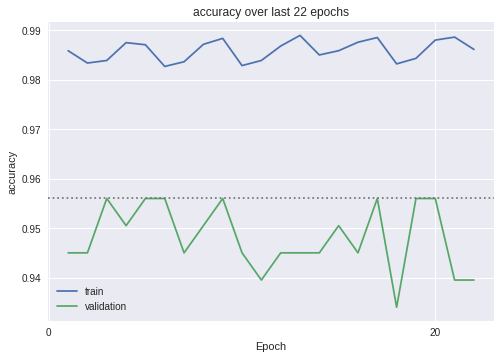

In [208]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [209]:
base_model.load_weights('weights.hdf5')
base_model.evaluate(X_ptbdb_test, y_ptbdb_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.9505


[0.19162200391292572, 0.9505494236946106]

Confusion matrix, without normalization
[[ 39   4]
 [  5 134]]


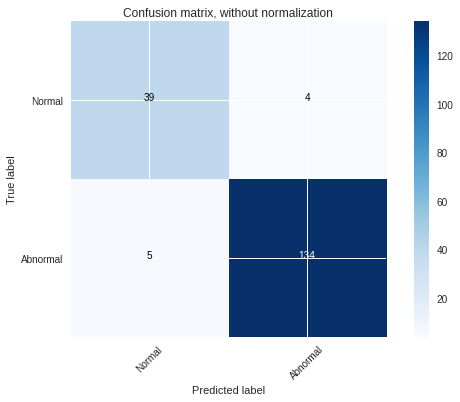

In [210]:
y_pred = (base_model.predict(X_ptbdb_test) > 0.5).astype("int32")

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

# ResNet model

In [175]:
def get_resnet_model(categories=2):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

  kernels = 32
  stride = 5

  inputs = keras.layers.Input([187,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

## ResNet PTB replication

In [176]:
X_ptbdbl_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdbl_train = np.expand_dims(y_ptbdb_train, -1)

X_ptbdbl_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdbl_val = np.expand_dims(y_ptbdb_val, -1)

X_ptbdbl_test = np.expand_dims(X_ptbdb_test, -1)
y_ptbdbl_test = np.expand_dims(y_ptbdb_test, -1)

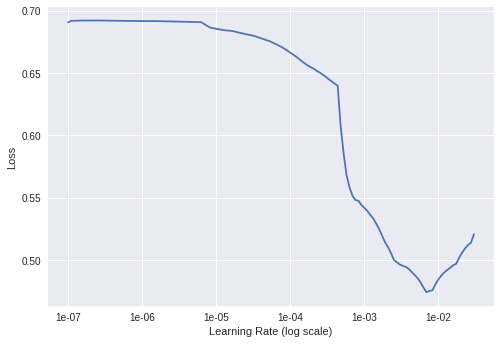

In [177]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdbl_train, y_ptbdbl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [213]:
# Set cyclical learning rate
N = X_ptbdbl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                           shuffle=True, batch_size=batch_size, epochs=75, callbacks=[save_best_weights])

Epoch 1/75
91/91 [==============================] - 2s 18ms/step - loss: 0.5696 - accuracy: 0.7195 - val_loss: 0.3688 - val_accuracy: 0.8516
Epoch 2/75
91/91 [==============================] - 1s 14ms/step - loss: 0.3231 - accuracy: 0.8626 - val_loss: 0.3022 - val_accuracy: 0.8956
Epoch 3/75
91/91 [==============================] - 1s 14ms/step - loss: 0.1849 - accuracy: 0.9301 - val_loss: 0.1020 - val_accuracy: 0.9615
Epoch 4/75
91/91 [==============================] - 1s 14ms/step - loss: 0.1139 - accuracy: 0.9573 - val_loss: 0.0715 - val_accuracy: 0.9780
Epoch 5/75
91/91 [==============================] - 1s 13ms/step - loss: 0.0967 - accuracy: 0.9642 - val_loss: 0.0926 - val_accuracy: 0.9451
Epoch 6/75
91/91 [==============================] - 1s 14ms/step - loss: 0.1029 - accuracy: 0.9616 - val_loss: 0.1007 - val_accuracy: 0.9670
Epoch 7/75
91/91 [==============================] - 1s 14ms/step - loss: 0.0935 - accuracy: 0.9650 - val_loss: 0.0384 - val_accuracy: 0.9835
Epoch 8/75
91

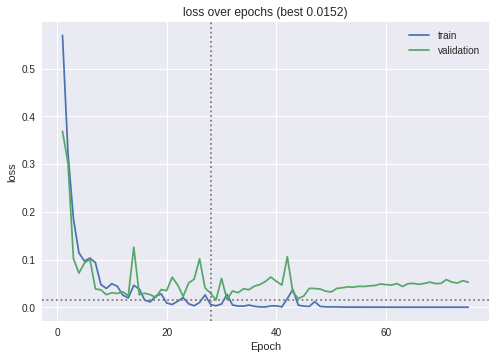

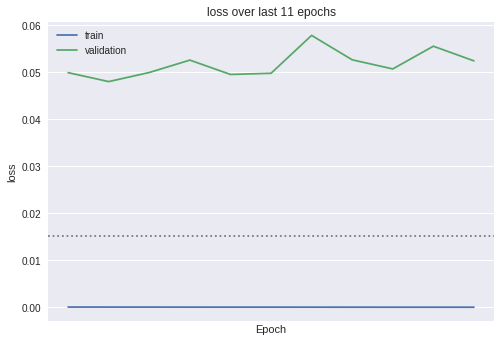

In [214]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

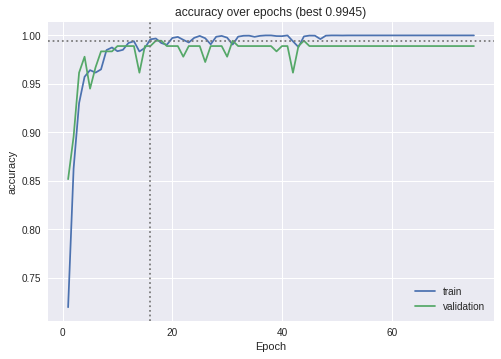

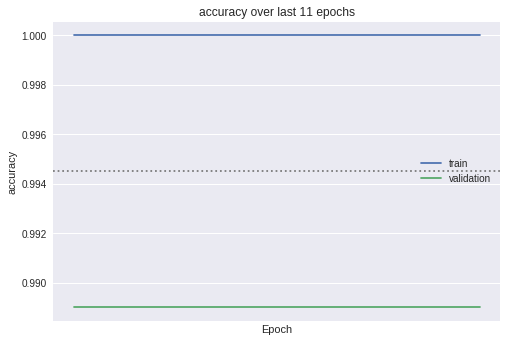

In [215]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [216]:
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_ptbdbl_test, y_ptbdbl_test)

6/6 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 0.9945


[0.009371606633067131, 0.9945054650306702]

Confusion matrix, without normalization
[[ 42   1]
 [  0 139]]


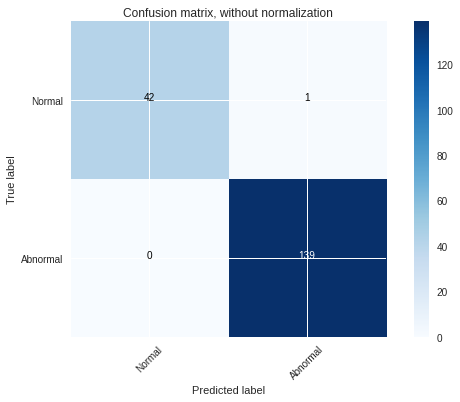

In [217]:
y_pred = (resnet_model.predict(X_ptbdbl_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

## ResNet MIH replication

In [187]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

# The 1D convolutions expect an extra dimension in the input data 
X_mitbihl_train = np.expand_dims(X_mitbih_train, -1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

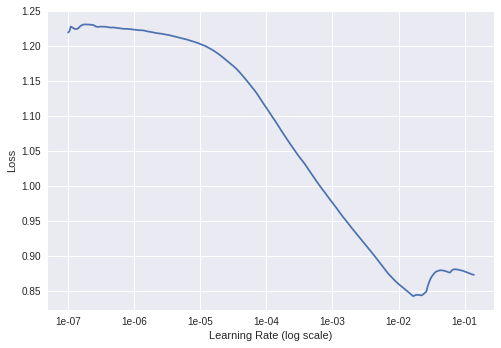

In [195]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(5) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-06, max_steps=50, smoothing=0.6)
_ = model.fit(X_mitbihl_train, y_mitbihl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [218]:
lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_resnet_model = get_resnet_model(5)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=50, callbacks=[save_best_weights])

Epoch 1/50
616/616 [==============================] - 9s 14ms/step - loss: 0.3801 - accuracy: 0.8673 - val_loss: 0.1719 - val_accuracy: 0.9515
Epoch 2/50
616/616 [==============================] - 9s 14ms/step - loss: 0.1347 - accuracy: 0.9646 - val_loss: 0.1325 - val_accuracy: 0.9648
Epoch 3/50
616/616 [==============================] - 9s 15ms/step - loss: 0.1046 - accuracy: 0.9728 - val_loss: 0.0862 - val_accuracy: 0.9764
Epoch 4/50
616/616 [==============================] - 9s 15ms/step - loss: 0.0871 - accuracy: 0.9765 - val_loss: 0.0786 - val_accuracy: 0.9773
Epoch 5/50
616/616 [==============================] - 9s 15ms/step - loss: 0.0721 - accuracy: 0.9799 - val_loss: 0.0825 - val_accuracy: 0.9762
Epoch 6/50
616/616 [==============================] - 9s 15ms/step - loss: 0.0662 - accuracy: 0.9812 - val_loss: 0.0628 - val_accuracy: 0.9821
Epoch 7/50
616/616 [==============================] - 9s 15ms/step - loss: 0.0594 - accuracy: 0.9828 - val_loss: 0.0632 - val_accuracy: 0.9814

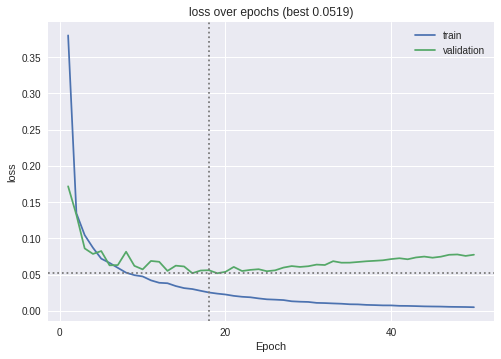

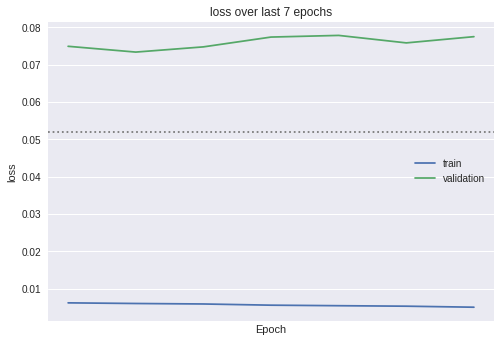

In [219]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

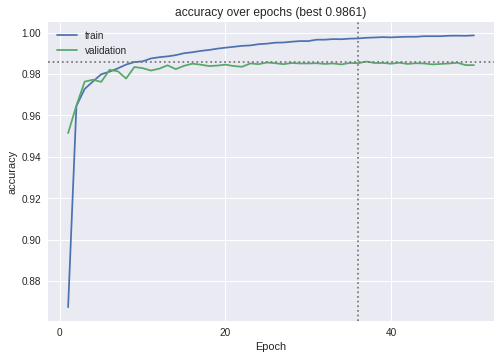

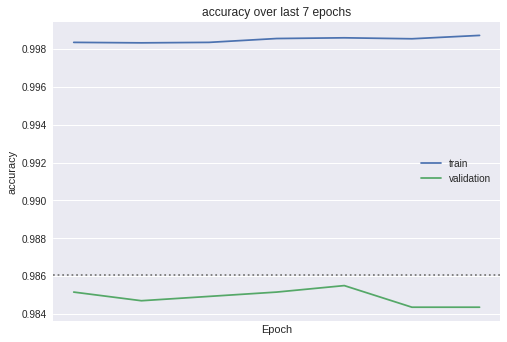

In [220]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [221]:
m_resnet_model.load_weights('weights.hdf5')
X_mitbih_test = m_resnet_model.evaluate(X_mitbihl_test, y_mitbihl_test)

685/685 [==============================] - 3s 4ms/step - loss: 0.0567 - accuracy: 0.9852


Confusion matrix, without normalization
[[18017    49    36    10     6]
 [  104   437    12     2     1]
 [   32     2  1397    13     4]
 [   19     0    16   127     0]
 [   14     2     3     0  1589]]


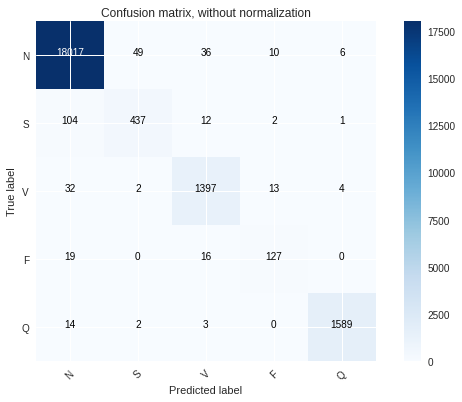

In [226]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')

# Transfer learning application

In [227]:
m_resnet_model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_286 (Conv1D)             (None, 183, 32)      192         input_27[0][0]                   
__________________________________________________________________________________________________
conv1d_287 (Conv1D)             (None, 183, 32)      5152        conv1d_286[0][0]                 
__________________________________________________________________________________________________
re_lu_260 (ReLU)                (None, 183, 32)      0           conv1d_287[0][0]                 
___________________________________________________________________________________________

In [231]:
# Reuse the MIT trained model, except the last three layers
def get_transfer_model(model):
  model.trainable = False
  model_input = model.inputs
  model_output = model.layers[-4].output

  X = keras.layers.Dense(32, activation='relu')(model_output)
  X = keras.layers.Dense(32, activation='relu')(X)
  out = keras.layers.Dense(1, activation='sigmoid')(X)

  transfer_model = keras.Model(inputs=model_input, outputs=out)
  return transfer_model

get_transfer_model(m_resnet_model).summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_330 (Conv1D)             (None, 183, 32)      192         input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_331 (Conv1D)             (None, 183, 32)      5152        conv1d_330[0][0]                 
__________________________________________________________________________________________________
re_lu_300 (ReLU)                (None, 183, 32)      0           conv1d_331[0][0]                 
___________________________________________________________________________________________

In [233]:
optimizer = keras.optimizers.Adam(lr=0.001)
transfer_model = get_transfer_model(model)

save_best_weights = ModelCheckpoint(filepath="tweights.hdf5", verbose=0, save_best_only=True)

transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                             shuffle=True, batch_size=128, epochs=50, callbacks=[save_best_weights])

Epoch 1/50
91/91 [==============================] - 1s 11ms/step - loss: 0.5808 - accuracy: 0.7710 - val_loss: 0.2710 - val_accuracy: 0.9011
Epoch 2/50
91/91 [==============================] - 1s 8ms/step - loss: 0.3115 - accuracy: 0.8789 - val_loss: 0.2480 - val_accuracy: 0.8956
Epoch 3/50
91/91 [==============================] - 1s 8ms/step - loss: 0.2808 - accuracy: 0.8887 - val_loss: 0.2302 - val_accuracy: 0.9121
Epoch 4/50
91/91 [==============================] - 1s 8ms/step - loss: 0.2583 - accuracy: 0.8985 - val_loss: 0.2206 - val_accuracy: 0.9121
Epoch 5/50
91/91 [==============================] - 1s 8ms/step - loss: 0.2423 - accuracy: 0.9048 - val_loss: 0.2146 - val_accuracy: 0.9231
Epoch 6/50
91/91 [==============================] - 1s 8ms/step - loss: 0.2275 - accuracy: 0.9115 - val_loss: 0.1934 - val_accuracy: 0.9396
Epoch 7/50
91/91 [==============================] - 1s 8ms/step - loss: 0.2072 - accuracy: 0.9186 - val_loss: 0.1926 - val_accuracy: 0.9231
Epoch 8/50
91/91 [=

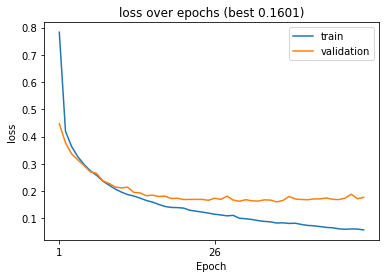

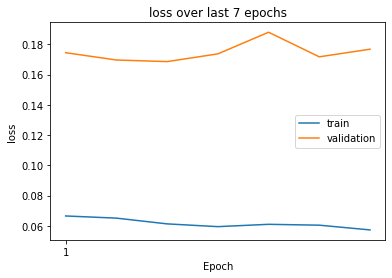

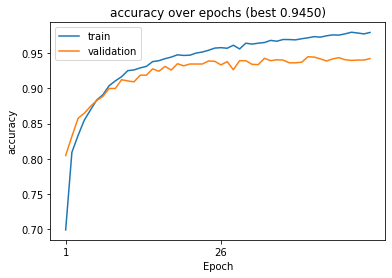

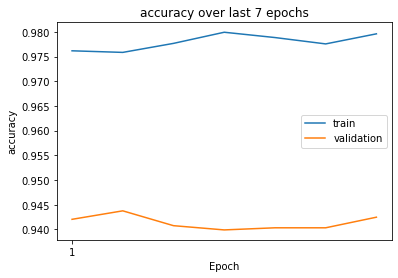

In [ ]:
pretty_plot(history, 'loss', lambda x: min(x))
pretty_plot(history, 'accuracy', lambda x: max(x))

In [238]:
transfer_model.load_weights('tweights.hdf5')
transfer_model.evaluate(X_ptbdbl_test, y_ptbdb_test)

6/6 [==============================] - 0s 5ms/step - loss: 0.0834 - accuracy: 0.9615


[0.08342593908309937, 0.9615384340286255]

Confusion matrix, without normalization
[[ 38   5]
 [  2 137]]


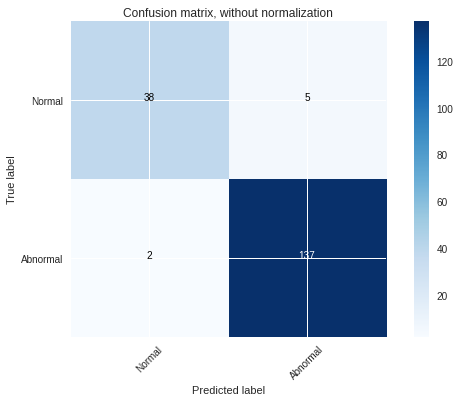

In [241]:
y_pred = (transfer_model.predict(X_ptbdbl_test) >= 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')